# Logistic Regression and SGD Homework 
***
**Name**: Pranav Kumar Sivakumar 
***

This assignment is due on Moodle by **5pm on Friday February 9th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***


In this homework you'll implement stochastic gradient ascent for logistic regression and you'll apply it to the task of determining whether documents are talking about automobiles or motorcycles.

<br>

![autos_motorcycles](autos_motorcycles.jpg "A car and a motorcycle")


<br>

You should not use any libraries that implement any of the functionality of logistic regression for this assignment; logistic regression is implemented in Scikit-Learn, but you should do everything by hand now. You'll be able to use library implementations of logistic regression in the future.

Here are the rules: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline 

### [5 points] Problem 1: Loading and Exploring the Data
***

The `Example` class will be used to store the features and labels associated with a single training or test example.  The `read_data` function will read in the text data and split it into training and test sets.  

 Load the data and then do the following: 
- Report the number of words in the vocabulary 
- Explain how the code is creating features (i.e. what text model is being used). 
- Go into the raw text files in the data directory and figure out which label (0/1) refers to which class of document (automobiles or motorcycles)

In [3]:
kSEED = 1735
kBIAS = "BIAS_CONSTANT"

np.random.seed(kSEED)

class Example:
    """
    Class to represent a document example
    """
    def __init__(self, label, words, vocab):
        """
        Create a new example

        :param label: The label (0 / 1) of the example
        :param words: The words in a list of "word:count" format
        :param vocab: The vocabulary to use as features (list)
        """
        self.nonzero = {}
        self.y = label
        self.x = np.zeros(len(vocab))
        for word, count in [x.split(":") for x in words]:
            if word in vocab:
                assert word != kBIAS, "Bias can't actually appear in document"
                self.x[vocab.index(word)] += float(count)
                self.nonzero[vocab.index(word)] = word
        self.x[0] = 1

def read_dataset(positive, negative, vocab, train_frac=0.9):
    """
    Reads in a text dataset with a given vocabulary

    :param positive: Positive examples
    :param negative: Negative examples
    :param vocab: A list of vocabulary words
    :param test_frac: How much of the data should be reserved for test
    """

    vocab = [x.split("\t")[0] for x in open(vocab, 'r') if '\t' in x]
    assert vocab[0] == kBIAS, \
        "First vocab word must be bias term (was %s)" % vocab[0]

    train_set = []
    test_set = []
    for label, input in [(1, positive), (0, negative)]:
        for line in open(input):
            ex = Example(label, line.split(), vocab)
            if np.random.random() <= train_frac:
                train_set.append(ex)
            else:
                test_set.append(ex)

    # Shuffle the data 
    np.random.shuffle(train_set)
    np.random.shuffle(test_set)

    return train_set, test_set, vocab

In [4]:
pos_fname = "../data/autos_motorcycles/positive"
neg_fname = "../data/autos_motorcycles/negative"
voc_fname = "../data/autos_motorcycles/vocab"
train_set, test_set, vocab = read_dataset(pos_fname, neg_fname, voc_fname)

In [5]:
print('The number of words in the vocabulary is %d' %len(vocab))

The number of words in the vocabulary is 5327


The text files containing the positive and the negative examples are read and counted with respect to the index(or position) in the vocabulary based on the labels as well. It is randomly split into training set and test set with a ratio of 9:1. This type of text model is called Bag of Words model. 

After checking the raw text files in the data directory and it appears to be that label 0 refers to class automobiles and 1 refers to class motorcycles.

### [25 points] Problem 2: Implementing SGD with Lazy Sparse Regularization
***

We've given you a class `LogReg` below which will train a logistic regression classifier to predict whether a document is talking about automobiles or motorcycles. 

**Part A**: In this problem you will modify the `sgd_update` function to perform **unregularized** stochastic gradient descent updates of the weights. Note that you should only update the weights for **non-zero** features, i.e. weights associated with words that appear in the current training example. The code below this cell demonstrates how to instantiate the class and train the classifier.   

We've also given you unit tests in the next cell based on the simple example worked out in  the Lecture 4 in-class notebook.  At first your code will fail both of them. When your code is working you should pass tests called `test_unreg` and `test_learnrate`.  Do not move on to **Part A** until your code passes both of them. 

In [91]:
class LogReg:
    def __init__(self, train_set, test_set, lam, eta=0.1):
        """
        Create a logistic regression classifier

        :param train_set: A set of training examples
        :param test_set: A set of test examples 
        :param lam: Regularization parameter
        :param eta: The learning rate to use 
        """
        
        # Store training and test sets 
        self.train_set = train_set
        self.test_set = test_set 
        
        # Initialize vector of weights to zero  
        self.w = np.zeros_like(train_set[0].x)
        
        # Store regularization parameter and eta function 
        self.lam = lam
        self.eta = eta
        
        # Create dictionary for lazy-sparse regularization
        self.last_update = dict()

        # Make sure regularization parameter is not negative 
        assert self.lam>= 0, "Regularization parameter must be non-negative"
        
        # Empty lists to store NLL and accuracy on train and test sets 
        self.train_nll = []
        self.test_nll = []
        self.train_acc = []
        self.test_acc = []
        
    def sigmoid(self,score, threshold=20.0):
        """
        Prevent overflow of exp by capping activation at 20.
        You do not need to change this function. 

        :param score: A real valued number to convert into a number between 0 and 1
        """

        # if score > threshold, cap value at score 
        if abs(score) > threshold:
            score = threshold * np.sign(score)

        return 1.0 / (1.0 + np.exp(-score)) 

    def compute_progress(self, examples):
        """
        Given a set of examples, compute the NLL and accuracy
        You shouldn't need to change this function. 

        :param examples: The dataset to score
        :return: A tuple of (log probability, accuracy)
        """

        NLL = 0.0
        num_correct = 0
        for ex in examples:
            # compute prob prediction
            p = self.sigmoid(self.w.dot(ex.x))
            # update negative log likelihood
            NLL = NLL - np.log(p) if ex.y==1 else NLL - np.log(1.0-p)
            # update number correct 
            num_correct += 1 if np.floor(p+.5)==ex.y else 0

        return NLL, float(num_correct) / float(len(examples))
    
    def train(self, num_epochs=1, isVerbose=False, report_step=5):
        """
        Train the logistic regression classifier on the training data 

        :param num_epochs: number of full passes over data to perform 
        :param isVerbose: boolean indicating whether to print progress
        :param report_step: how many iterations between recording progress
        """
        
        iteration = 0
        # Perform an epoch 
        for pp in range(num_epochs):
            # shuffle the data  
            np.random.shuffle(self.train_set)
            # loop over each training example
            for ex in self.train_set:
                # perform SGD update of weights 
                self.sgd_update(ex, iteration)
                # record progress 
                if iteration % report_step == 1:
                    train_nll, train_acc = self.compute_progress(self.train_set)
                    test_nll, test_acc = self.compute_progress(self.test_set)
                    self.train_nll.append(train_nll)
                    self.test_nll.append(test_nll)
                    self.train_acc.append(train_acc)
                    self.test_acc.append(test_acc)
                    if isVerbose:
                        print("Update {: 5d}  TrnNLL {: 8.3f}  TstNLL {: 8.3f}  TrnA {:.3f}  TstA {:.3f}"
                             .format(iteration-1, train_nll, test_nll, train_acc, test_acc))
                iteration += 1
    
    def sgd_update(self, train_example, iteration):
        """
        Compute a stochastic gradient update to improve the NLL 

        :param train_example: The example to take the gradient with respect to
        :param iteration: The current iteration (an integer)
        """
        
        # TODO implement LSR updates of weights 
        self.w = self.w 
        cal = 1-(2*self.eta*self.lam)
        muii = self.sigmoid(self.w.dot(train_example.x))- train_example.y
        for key in train_example.nonzero:
            self.w[key] = self.w[key] - (self.eta * muii * train_example.x[key])
            if key in self.last_update:
                self.w[key] = self.w[key] * (cal**(iteration-self.last_update[key]+1))
            else:
                self.w[key] = self.w[key] * (cal**(iteration+1))
            self.last_update[key]=iteration +1
        self.w[0] = self.w[0]  - (self.eta * muii)
        return self.w

In [92]:
lr = LogReg(train_set, test_set, lam=0, eta=0.1)
lr.train(isVerbose=True)

Update     0  TrnNLL  760.813  TstNLL   78.397  TrnA 0.498  TstA 0.534
Update     5  TrnNLL  571.809  TstNLL   62.634  TrnA 0.717  TstA 0.707
Update    10  TrnNLL  530.891  TstNLL   59.793  TrnA 0.737  TstA 0.698
Update    15  TrnNLL  513.176  TstNLL   58.195  TrnA 0.755  TstA 0.724
Update    20  TrnNLL  512.286  TstNLL   54.456  TrnA 0.755  TstA 0.767
Update    25  TrnNLL  444.662  TstNLL   49.824  TrnA 0.800  TstA 0.802
Update    30  TrnNLL  439.999  TstNLL   48.726  TrnA 0.809  TstA 0.810
Update    35  TrnNLL  430.301  TstNLL   47.502  TrnA 0.814  TstA 0.819
Update    40  TrnNLL  424.245  TstNLL   46.419  TrnA 0.818  TstA 0.819
Update    45  TrnNLL  457.499  TstNLL   49.872  TrnA 0.798  TstA 0.793
Update    50  TrnNLL  371.657  TstNLL   40.597  TrnA 0.854  TstA 0.853
Update    55  TrnNLL  353.206  TstNLL   38.423  TrnA 0.861  TstA 0.853
Update    60  TrnNLL  345.896  TstNLL   38.429  TrnA 0.861  TstA 0.836
Update    65  TrnNLL  337.626  TstNLL   37.370  TrnA 0.867  TstA 0.862
Update

Update   620  TrnNLL  132.879  TstNLL   21.348  TrnA 0.954  TstA 0.948
Update   625  TrnNLL  125.209  TstNLL   19.831  TrnA 0.963  TstA 0.948
Update   630  TrnNLL  124.181  TstNLL   19.433  TrnA 0.962  TstA 0.948
Update   635  TrnNLL  122.024  TstNLL   18.379  TrnA 0.961  TstA 0.957
Update   640  TrnNLL  121.484  TstNLL   17.798  TrnA 0.964  TstA 0.948
Update   645  TrnNLL  120.513  TstNLL   17.208  TrnA 0.964  TstA 0.940
Update   650  TrnNLL  112.094  TstNLL   17.251  TrnA 0.965  TstA 0.957
Update   655  TrnNLL  112.087  TstNLL   17.244  TrnA 0.965  TstA 0.957
Update   660  TrnNLL  116.093  TstNLL   15.235  TrnA 0.967  TstA 0.948
Update   665  TrnNLL  118.819  TstNLL   15.759  TrnA 0.966  TstA 0.940
Update   670  TrnNLL  113.174  TstNLL   14.910  TrnA 0.966  TstA 0.940
Update   675  TrnNLL  106.573  TstNLL   14.340  TrnA 0.970  TstA 0.957
Update   680  TrnNLL  106.663  TstNLL   14.337  TrnA 0.970  TstA 0.957
Update   685  TrnNLL   98.374  TstNLL   15.272  TrnA 0.974  TstA 0.966
Update

The unit tests are located in the script `tests.py` in this directory.  Execute the following cell to call the script and run the tests. 

In [93]:
%run -i tests.py "part A"

test_unreg (__main__.TestLogReg) ... ok
test_learnrate (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.008s

OK


**Part B**: After your unregularized updates are working, modify the `sgd_update` function again to perform regularized updates using **Lazy Sparse Regularization**. Note that you should not regularize the bias weight. See the Lecture 4 in-class notebook for a refresher on LSR. **Note**: After implementing LSR, your code should still pass the unit tests for **Part A** when `lam = 0`. 

We've given you a third unit test in the next cell called `test_reg` based on the simple example of LSR worked out in  the Lecture 4 in-class notebook.  Do not move on to **Problem 3** until your code passes the test. 

In [94]:
%run -i tests.py "part B"

test_reg (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


### [10 points] Problem 3: Hyperparameter Tuning 
***

**Part A**: Perform a systematic study of the effect of the regularization parameter on the accuracy of your classifier on the test set.  Which choice of `lam` seems to do the best?  Justify your conclusion with some kind of graphic. 

Text(0,0.5,'Accuracy')

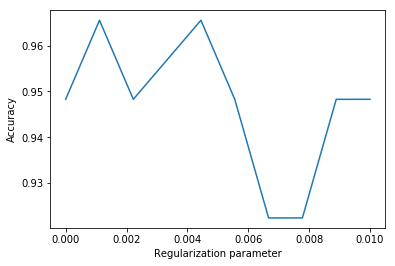

In [106]:
acc = []
a = np.linspace(0, 0.01, num=10)
for num in a: 
    lr = LogReg(train_set, test_set, lam=num, eta=0.1)
    lr.train()
    acc.append(lr.test_acc[-1])
plt.plot(a,acc)
plt.xlabel("Regularization parameter")
plt.ylabel("Accuracy")

In [107]:
print(a[acc.index(max(acc))])

0.00111111111111


Based on the above illustration, We can study the effect of regularization parameter on the accuracy of the classifier and also we can conclude the accuracy is maximum with the regularization parameter value as 0.001 (most of the time). 

**Part B**: For the value of `lam` chosen in **Part A** perform a systematic study of the choice of learning rate on the speed of convergence SGD.  Which learning rate seems to give the fastest convergence?  Justify your conclusion with some kind of graphic. 

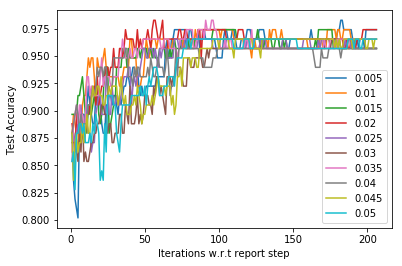

[2021.8893678160925, 2032.6508620689658, 2034.7485632183909, 2047.9382183908056, 2021.875, 1995.2945402298853, 2031.3577586206898, 2015.7183908045979, 2010.7471264367821, 2006.4655172413798]
[0.9741379310344828, 0.9655172413793104, 0.9568965517241379, 0.9741379310344828, 0.9568965517241379, 0.9568965517241379, 0.9655172413793104, 0.9568965517241379, 0.9655172413793104, 0.9655172413793104]


In [41]:
from scipy.integrate import simps
etas = np.linspace(0.005, 0.05, num=10)
area= []
final_acc=[]
for i in range(len(etas)):
    lr1 = LogReg(train_set, test_set, lam=0.001, eta=etas[i])
    lr1.train(num_epochs=2,report_step = 10)
    plt.plot(np.linspace(1,len(lr1.test_acc[10:]),len(lr1.test_acc[10:])),lr1.test_acc[10:], label = str(etas[i]))
    area.append(simps(lr1.test_acc, dx=10))
    final_acc.append(lr1.test_acc[-1])
plt.legend(loc='best')
plt.xlabel('Iterations w.r.t report step')
plt.ylabel('Test Accuracy')
plt.show()
print(area)
print(final_acc)

The above graph is printed conveniently. The values above are the areas under the curves and final test accuracies based on the eta values. 

In [90]:
print("The learning rate that reaches it's maximum area on the validation set in the fewest amount of iterations is "+str(etas[np.array(area).argsort()[::-1][0]]))
print("The learning rate leads to the highest accuracy ("+str(max(final_acc)*100)[:5] + " %) on the validation set is "+str(etas[np.array(final_acc).argsort()[::-1][0]]))

The learning rate that reaches it's maximum area on the validation set in the fewest amount of iterations is 0.02
The learning rate leads to the highest accuracy (97.41 %) on the validation set is 0.02


### [10 points] Problem 4: Identifying Predictive and Non-Predictive Words 
***

**Part A**: Find the top 10 words that are the best predictors for each class.  Explain mathematically how you identified them and show any code that you used to find them. 

In [70]:
lr2 = LogReg(train_set, test_set, lam=0.001, eta=0.02)
lr2.train(num_epochs=3)

In [74]:
print("The best predictors for the motorcycle class: {} ".format([vocab[i] for i in lr2.w.argsort()[::-1][:10]]))
print("The best predictors for the automobile class: {} ".format([vocab[i] for i in lr2.w.argsort()[:10]]))

The best predictors for the motorcycle class: ['bike', 'dod', 'bikes', 'ride', 'riding', 'helmet', 'rider', 'jonathan', 'shaft', 'moa'] 
The best predictors for the automobile class: ['car', 'cars', 'toyota', 'ford', 'warning', 'saturn', 'dealer', 'eliot', 'parts', 'usa'] 


The best predictors of each of the class are those at the respective extremes of all the weights when they are sorted.

$$
w_k \leftarrow w_k - \eta[\textrm{sigm}({\bf w}^T{\bf x}_i)-y_i]x_{ik}
$$

In the above equation, the label value (y) is subtracted in the inner term which affects the weights w.r.t to their classes, and also drives them towards their corresponding extremity in the weight space.

**Part B**: Find the 10 words that are the worst predictors for class.  Explain mathematically how you identified them and show any code that you used to find them. 

In [80]:
print("The worst predictors for class: {} ".format([vocab[i] for i in lr2.w.argsort()[len(lr2.w)//2-5:len(lr2.w)//2+5]]))

The worst predictors for class: ['seriously', 'buyers', 'agreement', 'immediately', 'weak', 'million', 'labor', 'credit', 'records', 'harsh'] 


For both the class the worst predictors are the words with the weights around the median of all the weights.
These are the words that might occur in documents belonging to both the classes.